In [1]:
import numpy as np
import utils
import matplotlib.pyplot as plt
import math
import importlib as imp

/opt/anaconda3/envs/pandora/lib/python3.9/site-packages/lightkurve/config/__init__.py:119: UserWarning: The default Lightkurve cache directory, used by download(), etc., has been moved to /Users/raeholcomb/.lightkurve/cache. Please move all the files in the legacy directory /Users/raeholcomb/.lightkurve-cache to the new location and remove the legacy directory. Refer to https://docs.lightkurve.org/reference/config.html#default-cache-directory-migration for more information.
  warnings.warn(


In [305]:
imp.reload(utils)

<module 'utils' from '/Users/raeholcomb/Documents/GitHub/pandora-me/utils.py'>

In [244]:
import astropy.units as u
from astropy.io import fits
from astropy.wcs import WCS, Sip
from astropy.coordinates import Angle
from astropy.coordinates import SkyCoord
from astropy.table import Table
from astroquery.mast import Catalogs

from tess_stars2px import tess_stars2px_function_entry as tess_stars2px
from tess_stars2px import TESS_Spacecraft_Pointing_Data


In [3]:
import sys
sys.path.insert(0, '../pandora-sim/src')

import pandorasim as psim

In [4]:
# import sys
# sys.path.insert(0, '../pandora-sat/src')

# from pandorasat import PandoraSat
import pandorasat as psat
ps = psat.PandoraSat()


In [5]:
# HELPER FUNCTIONS



#probably not needed anymore
def rotate(origin, px, py, angle):
    """
    Rotate a point counterclockwise by a given angle around a given origin.

    The angle should be given in radians.
    """
    ox, oy = origin
    # px, py = point

    qx = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
    qy = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)
    return qx, qy

def makeGaussian(size_x, size_y, fwhm=1, center=None):
    """Make a square gaussian kernel.

    size is the length of a side of the square
    fwhm is full-width-half-maximum (units of pixels), which
    can be thought of as an effective radius.

    Note: NOT normalized correctly! But that shouldn't matter since this is a place holder for now.
    """
    x = np.arange(0, size_x, 1, float)[np.newaxis, :]
    y = np.arange(0, size_y, 1, float)[:, np.newaxis]

    if center is None:
        x0 = size_x // 2
        y0 = size_y // 2
    else:
        x0 = center[0]
        y0 = center[1]

    # make and normalize so that the who image sums to 1
    arr = np.exp(-4 * np.log(2) * ((x - x0) ** 2 + (y - y0) ** 2) / fwhm**2)
    return arr


In [6]:
# from .detector import Detector
# Detector = psim.detector.Detector

In [7]:
def get_wcs(
    detector,
    # detector: Detector,
    target_ra: u.Quantity,
    target_dec: u.Quantity,
    crpix1: int = None,
    crpix2: int = None,
    theta: u.Quantity = 0 * u.deg,
    distortion_file: str = None,
    order: int = 3,
    xreflect: bool = True,
    yreflect: bool = False,    
) -> WCS.wcs:
    """Get the World Coordinate System for a detector

    Parameters:
    -----------
    detector : pandorasim.Detector
        The detector to build the WCS for
    target_ra: astropy.units.Quantity
        The target RA in degrees
    target_dec: astropy.units.Quantity
        The target Dec in degrees
    theta: astropy.units.Quantity
        The observatory angle in degrees
    distortion_file: str
        Optional file path to a distortion CSV file. See `read_distortion_file`
    """
    # xreflect = True
    # yreflect = False
    hdu = fits.PrimaryHDU()
    hdu.header["CTYPE1"] = "RA---TAN"
    hdu.header["CTYPE2"] = "DEC--TAN"
    matrix = np.asarray(
        [
            [np.cos(theta).value, -np.sin(theta).value],
            [np.sin(theta).value, np.cos(theta).value],
        ]
    )
    hdu.header["CRVAL1"] = target_ra.value
    hdu.header["CRVAL2"] = target_dec.value
    for idx in range(2):
        for jdx in range(2):
            hdu.header[f"PC{idx+1}_{jdx+1}"] = matrix[idx, jdx]
    hdu.header["CRPIX1"] = (
        detector.naxis1.value // 2 if crpix1 is None else crpix1
    )
    hdu.header["CRPIX2"] = (
        detector.naxis2.value // 2 if crpix2 is None else crpix2
    )
    hdu.header["NAXIS1"] = detector.naxis1.value
    hdu.header["NAXIS2"] = detector.naxis2.value
    hdu.header["CDELT1"] = detector.pixel_scale.to(u.deg / u.pixel).value * (
        -1
    ) ** (int(xreflect))
    hdu.header["CDELT2"] = detector.pixel_scale.to(u.deg / u.pixel).value * (
        -1
    ) ** (int(yreflect))
    if distortion_file is not None:
        wcs = _get_distorted_wcs(
            detector, hdu.header, distortion_file, order=order
        )
    else:
        wcs = WCS(hdu.header)
    return wcs

In [204]:
# set up TESS detector object
from dataclasses import dataclass

@dataclass
class TessDetector:
    """Holds information on a toy version of the TESS detector

    Attributes
    ----------
    name: str
        Name of the detector. This will determine which files are loaded. This
        will be `"visda"` for this detector
    pixel_scale: float
        The pixel scale of the detector in arcseconds/pixel
    pixel_size: float
        The pixel size in microns/mm
    """

    def __init__(self, shape=(20,20)):
        """Some detector specific functions to run on initialization"""
        # self.shape = (2048, 2048)
        self.shape = shape # make property

    @property
    def pixel_scale(self):
        """Pixel scale of the detector"""
        return 21 * u.arcsec / u.pixel

    @property
    def pixel_size(self):
        """Size of a pixel"""
        return 6.5 * u.um / u.pixel

    @property
    def naxis1(self):
        """WCS's are COLUMN major, so naxis1 is the number of columns"""
        return self.shape[1] * u.pixel

    @property
    def naxis2(self):
        """WCS's are COLUMN major, so naxis2 is the number of rows"""
        return self.shape[0] * u.pixel

    def flux_to_mag(self, flux, reference_mag=20.44):
        """Converts a TESS magnitude to a flux in e-/s. The TESS reference magnitude is taken to be 20.44. If needed, the Kepler reference flux is 1.74e5 electrons/sec.
        
        Parameters
        ----------
        flux : float
            The total flux of the target on the CCD in electrons/sec.
        reference_mag: int
            The zeropoint reference magnitude for TESS. Typically 20.44 +/-0.05.
        reference_mag: float

        Returns
        -------
        Tmag: float
            TESS magnitude of the target.
        
        """
        # kepler_mag = 12 - 2.5 * np.log10(flux / reference_flux)
        mag = -2.5 * np.log10(flux) + reference_mag
        return mag


    def mag_to_flux(self, Tmag, reference_mag=20.44):
        """Converts a TESS magnitude to a flux in e-/s. The TESS reference magnitude is taken to be 20.44. If needed, the Kepler reference flux is 1.74e5 electrons/sec.
        
        Parameters
        ----------
        Tmag: float
            TESS magnitude of the target.
        reference_mag: int
            The zeropoint reference magnitude for TESS. Typically 20.44 +/-0.05.

        Returns
        -------
        flux : float
            The total flux of the target on the CCD in electrons/sec.
        """
        # fkep = (10.0 ** (-0.4 * (mag - 12.0))) * 
        return 10 ** (-(Tmag - reference_mag)/2.5)


# toy tess detector
tessda = TessDetector()

## Download Data

In [ ]:
# download a cutout
cutout_size=30

# set up a tess detector of the right size
tessda = TessDetector(shape=(cutout_size,cutout_size))

# grab the TESS FFI cut out
tic = 396696273
name = "TIC " + str(tic)
tpf = lk.search_tesscut(name, sector=3).download(cutout_size=cutout_size)


In [268]:
# get matching TIC catalog
cat = Catalogs.query_object(name, catalog="TIC", radius=utils.pixels_to_radius(cutout_size))
cat = cat[cat["Tmag"] < 17] # apply brightness cutoff



In [270]:
# get the gaia catalog
target_coords = SkyCoord(cat[ind]['ra'], cat[ind]['dec'], unit="deg")
ref_coords = SkyCoord(tpf.ra, tpf.dec, unit="deg")
gaia_cat = Table(utils.get_sky_catalog(ra=ref_coords.ra.deg, dec=ref_coords.dec.deg, radius=utils.pixels_to_radius(cutout_size)))

# extract the ra and dec into their own columns
gaia_cat['ra'] = gaia_cat['coords'].ra.value
gaia_cat['dec'] = gaia_cat['coords'].dec.value
# gaia_cat = gaia_cat[gaia_cat['gmag']<18]

In [264]:
# Set up the wcs
ref_coords = SkyCoord(tpf.ra, tpf.dec, unit="deg")
# x = Angle(cat[ind]['ra'] * u.deg)
# y = Angle(cat[ind]['dec'] * u.deg)

detector = tessda
ref_ra = Angle(tpf.ra * u.deg)
ref_dec = Angle(tpf.dec * u.deg)
ref_p1 = tpf.get_header(1)['1CRPX4']
ref_p2 = tpf.get_header(1)['2CRPX4']
roll = Angle(TESS_Spacecraft_Pointing_Data.rolls[tpf.sector-1] * u.deg)

midpoint = ((tpf.row+cutout_size/2), (tpf.column+cutout_size/2))


# tess_wcs = get_wcs(tessda, ref_coords.ra, ref_coords.dec, ref_p1, ref_p2, roll) 


In [265]:
print(ref_p1, ref_p2)
print(midpoint)

15.435626525212 15.553329377711
(606.0, 997.0)


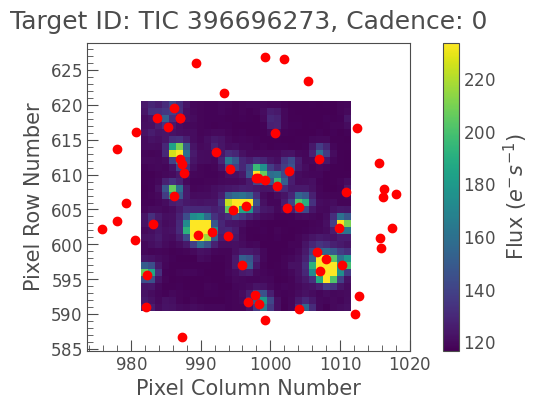

In [269]:
# check that everything lines up
# make the tess wcs0
tess_wcs = get_wcs(tessda, ref_coords.ra, ref_coords.dec, ref_p1, ref_p2, roll, xreflect=False, yreflect=True) 

# apply the wcs to convert the catalog coords to pixels
# pix_x, pix_y = tess_wcs.all_world2pix(gaia_cat['ra'], gaia_cat['dec'], 0)
pix_x, pix_y = tess_wcs.all_world2pix(cat['ra'], cat['dec'], 0)

# plot
ax = tpf.plot()
ax.scatter(pix_y+midpoint[1]-tessda.naxis1.value/2, pix_x+midpoint[0]-tessda.naxis2.value/2, color='r')
# ax.scatter(r1, r2, color='r')
plt.show()

# Build TESS WCS0

## WCS0

In [10]:
# # these don't seem to work
ps = psat.PandoraSat()
print(ps.NIRDA.pixel_scale)
print(ps.Hardware.mirror_diameter)
# print(ps.VISDA.sensitivity(wavelength))
print(ps.Orbit.period)

1.19 arcsec / pix
0.43 m
90.0 min


In [11]:
# well, I can't figure out the pandorasat stuff, so let's get the tess and gaia stuff figured out
import lightkurve as lk
from astroquery.mast import Catalogs

In [307]:
cat[cat['Tmag'] < 12]

ID,ra,dec,pmRA,pmDEC,Tmag,objType,typeSrc,version,HIP,TYC,UCAC,TWOMASS,SDSS,ALLWISE,GAIA,APASS,KIC,POSflag,e_pmRA,e_pmDEC,PMflag,plx,e_plx,PARflag,gallong,gallat,eclong,eclat,Bmag,e_Bmag,Vmag,e_Vmag,umag,e_umag,gmag,e_gmag,rmag,e_rmag,imag,e_imag,zmag,e_zmag,Jmag,e_Jmag,Hmag,e_Hmag,Kmag,e_Kmag,TWOMflag,prox,w1mag,e_w1mag,w2mag,e_w2mag,w3mag,e_w3mag,w4mag,e_w4mag,GAIAmag,e_GAIAmag,e_Tmag,TESSflag,SPFlag,Teff,e_Teff,logg,e_logg,MH,e_MH,rad,e_rad,mass,e_mass,rho,e_rho,lumclass,lum,e_lum,d,e_d,ebv,e_ebv,numcont,contratio,disposition,duplicate_id,priority,eneg_EBV,epos_EBV,EBVflag,eneg_Mass,epos_Mass,eneg_Rad,epos_Rad,eneg_rho,epos_rho,eneg_logg,epos_logg,eneg_lum,epos_lum,eneg_dist,epos_dist,distflag,eneg_Teff,epos_Teff,TeffFlag,gaiabp,e_gaiabp,gaiarp,e_gaiarp,gaiaqflag,starchareFlag,VmagFlag,BmagFlag,splists,e_RA,e_Dec,RA_orig,Dec_orig,e_RA_orig,e_Dec_orig,raddflag,wdflag,dstArcSec
str9,float64,float64,float64,float64,float64,str4,str7,str8,str1,str12,str10,str16,str1,str19,str19,str8,str1,str7,float64,float64,str5,float64,float64,str5,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str19,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str5,str5,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str5,float64,float64,float64,float64,float64,float64,int64,float64,str1,str1,float64,float64,float64,str8,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str6,float64,float64,str5,float64,float64,float64,float64,int64,str1,str8,str8,str13,float64,float64,float64,float64,float64,float64,int64,int64,float64
396696286,65.2981915271218,-55.1908202890712,2.59024,34.1552,11.5959,STAR,tmgaia2,20190415,--,8505-01712-1,175-004293,04211156-5511268,--,J042111.57-551126.6,4778971597288694400,27219510,--,tmgaia2,0.0471396,0.048294,gaia2,2.10389,0.0227366,gaia2,264.586921988694,-43.1647438507799,32.026351159557,-73.6575226166382,12.745,0.408,12.305,0.029,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,11.043,0.024,10.729,0.022,10.664,0.024,AAA-222-111-000-0-0,nan,10.65,0.022,10.683,0.02,10.619,0.047,9.665,0.423,11.9938,0.000194,0.006,rered,gaia2,6009.0,129.213,4.13618,0.0789917,nan,nan,1.49144,0.0710427,1.11,0.148572,0.334582,0.0726177,DWARF,2.61286664,0.1163685,468.898,5.037,0.00522104,0.009475655,54,0.00717140641,--,--,0.00089135,0.00931675,0.00963456,schlegel,0.148538,0.148606,0.0917709,0.0503146,0.05853,0.0867054,0.0749731,0.0830102,0.101325,0.131412,4.984,5.09,bj2018,133.383,125.043,dered,12.2965,0.001499,11.5407,0.001022,1,--,tycho2v3,tycho2b3,--,0.824692967300599,0.748915481600369,65.2982110638079,-55.1906732319651,0.019915120473099,0.0231692971777907,1,0,168.68389652978496
396720662,65.440385,-55.122144,8.3,17.7,11.394,STAR,2mass,20190415,--,8505-01417-1,175-004305,04214569-5507197,--,J042145.69-550719.5,--,27219757,--,2mass,3.3,3.0,tic7,nan,nan,--,264.467777,-43.103448,32.403311,-73.649879,12.323,0.289,11.724,0.02,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,10.926,0.028,10.731,0.025,10.65,0.023,AAA-222-111-000-0-0,nan,10.628,0.023,10.66,0.02,10.587,0.045,9.438,0.382,nan,nan,0.037,vjk,splin,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,DWARF,nan,nan,404.686,nan,nan,nan,--,nan,--,--,nan,nan,nan,--,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,--,nan,nan,--,nan,nan,nan,nan,--,--,tycho2v3,tycho2b3,--,60.0,70.0,65.440385,-55.122143,60.0,70.0,1,0,294.9375404484453


In [159]:
# download a cutout
tic = 396696273
name = "TIC " + str(tic)

# grab the TESS FFI cut out
cutout_size=30
tpf = lk.search_tesscut(name, sector=3).download(cutout_size=cutout_size)

# get matching catalog
cat = Catalogs.query_object(name, catalog="TIC", radius=utils.pixels_to_radius(cutout_size))
cat = cat[cat["Tmag"] < 16] # apply brightness cutoff

RemoteServiceError: A network-related or instance-specific error occurred while establishing a connection to SQL Server. The server was not found or was not accessible. Verify that the instance name is correct and that SQL Server is configured to allow remote connections. (provider: Named Pipes Provider, error: 40 - Could not open a connection to SQL Server)

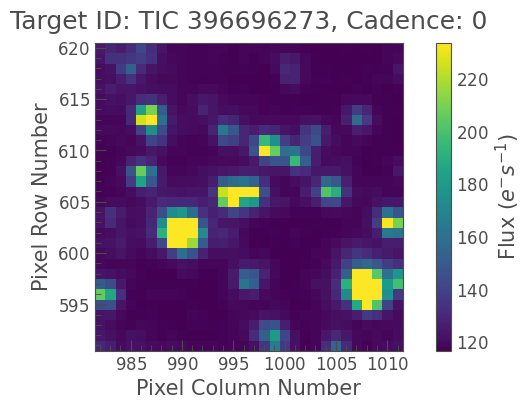

In [205]:
# our only known information is the RA, DEC, and roll for the middle of the image
# extract those

tessda = TessDetector(shape=(cutout_size,cutout_size))

ra = tpf.meta['RA_OBJ']
dec = tpf.meta['DEC_OBJ']
# roll = 90.   # idk I'm making this up right now and it's in degrees
# tpf.meta.keys()

# plot the objects in the source catalog
ax = tpf.plot()
# ax.scatter(cat['ra'], cat['dec'])
plt.show()

In [14]:
plt.imshow(tpf_clean[0])
plt.colorbar()
plt.show()

plt.imshow(mean)
plt.colorbar()
plt.show()

NameError: name 'tpf_clean' is not defined

In [206]:
# need to convert the ra and dec into pixel numbers
# tpf.meta['1CDLT4']
position = (tpf.row, tpf.column)
midpoint = ((position[0]+cutout_size/2), (position[1]+cutout_size/2))
# midpoint = ((position[0]+tpf.get_header(1)['1CRPX4']), (position[1]+tpf.get_header(1)['2CRPX4']))
print(midpoint)

(606.0, 997.0)


In [207]:
from astropy.coordinates import Angle
Angle('10.2345d').radian

0.17862572229535967

In [208]:
tessda.pixel_scale.value
cat[1]['ra']

65.2967867766935

In [209]:
# Get spacecraft roll from TESSPOINT
from tess_stars2px import tess_stars2px_function_entry as tess_stars2px
from tess_stars2px import TESS_Spacecraft_Pointing_Data
# ra,dec = 226.337147,36.786975
# sectors = tess_stars2px(8675309, 226.337147,36.786975)[3]
# tess_stars2px(8675309, 226.337147,36.786975, trySector=23)

# how to get the roll
TESS_Spacecraft_Pointing_Data.rolls[tpf.sector-1]


213.0384

In [210]:
from astropy.coordinates import SkyCoord
# (Angle(tpf.ra * u.deg))

c = SkyCoord(tpf.ra, tpf.dec, unit="deg")
c.ra.value

# print(target_coords)
# print(ref_coords)
tpf.get_header(1)['1CRPX4']

15.435626525212

In [211]:
ind = 10
target_coords = SkyCoord(cat[ind]['ra'], cat[ind]['dec'], unit="deg")
ref_coords = SkyCoord(tpf.ra, tpf.dec, unit="deg")
# x = Angle(cat[ind]['ra'] * u.deg)
# y = Angle(cat[ind]['dec'] * u.deg)

detector = tessda
ref_ra = Angle(tpf.ra * u.deg)
ref_dec = Angle(tpf.dec * u.deg)
ref_p1 = tpf.get_header(1)['1CRPX4']
ref_p2 = tpf.get_header(1)['2CRPX4']
roll = Angle( TESS_Spacecraft_Pointing_Data.rolls[tpf.sector-1] * u.deg)

tess_wcs = get_wcs(tessda, ref_coords.ra, ref_coords.dec, ref_p1, ref_p2, roll) 

# p1 = (x-ref_ra)/detector.pixel_scale.value + ref_p1
# p2 = (y-ref_dec)/detector.pixel_scale.value + ref_p2

# def transform_coord_to_pix(ra, dec):
#     p1 = (ra-ref_ra)/detector.pixel_scale.to(u.deg / u.pixel).value + ref_p1
#     p2 = (dec-ref_dec)/detector.pixel_scale.to(u.deg / u.pixel).value + ref_p2  

#     return p1, p2

# p1_arr, p2_arr = (transform_coord_to_pix(cat['ra'],cat['dec']))


In [212]:
tess_wcs

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 65.30227729607  -55.14402275607  
CRPIX : 15.435626525212  15.553329377711  
PC1_1 PC1_2  : -0.8383053590323319  0.5452009950629887  
PC2_1 PC2_2  : -0.5452009950629887  -0.8383053590323319  
CDELT : -0.00583333333333333  0.005833333333333334  
NAXIS : 30.0  30.0

In [213]:
ref_coords
ref_p1

15.435626525212

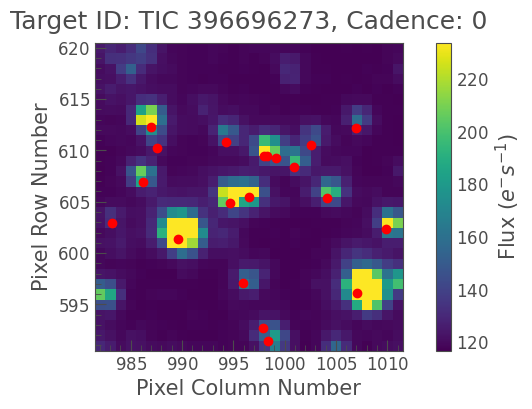

In [215]:
# make the tess wcs0
tess_wcs = get_wcs(tessda, ref_coords.ra, ref_coords.dec, ref_p1, ref_p2, roll, xreflect=False, yreflect=True) 

# apply the wcs to convert the catalog coords to pixels
pix_x, pix_y = tess_wcs.all_world2pix(cat['ra'], cat['dec'], 0)

# plot
ax = tpf.plot()
# ax.scatter(pix_y+midpoint[1]-tessda.naxis1.value/2, pix_x+midpoint[0]-tessda.naxis2.value/2, color='r')
ax.scatter(pix_y+midpoint[1]-tessda.naxis1.value/2, pix_x+midpoint[0]-tessda.naxis2.value/2, color='r')
# ax.scatter(r1, r2, color='r')
plt.show()

In [230]:
imp.reload(utils)

<module 'utils' from '/Users/raeholcomb/Documents/GitHub/pandora-me/utils.py'>

In [33]:
# figure out gaia coord query
# from .utils import get_phoenix_model, get_planets, get_sky_catalog
# from pandorasim.utils import get_sky_catalog
from astropy.table import Table
# psim.utils.get_sky_catalog

# gaia_cat = Table(get_sky_catalog(ra=ref_coords.ra.deg, dec=ref_coords.dec.deg, radius=utils.pixels_to_radius(cutout_size),  
#                 gaia_keys=tuple(["source_id", "ra", "dec", "parallax", "pmra", "pmdec", "radial_velocity", "ruwe", "phot_bp_mean_mag", "teff_gspphot", "logg_gspphot", "phot_g_mean_flux", "phot_g_mean_mag"])))
gaia_cat = Table(utils.get_sky_catalog(ra=ref_coords.ra.deg, dec=ref_coords.dec.deg, radius=utils.pixels_to_radius(cutout_size)))
# ^ need to generalize pixels_to_radius function
# follow up with christina about which mag band to use (gaia g, tess redband)


In [34]:
gaia_cat[:3]

jmag,bmag,gmag,gflux,ang_sep,teff,logg,RUWE,coords,source_id
,,,,deg,K,,,"deg,deg,pc",
float32,float32,float32,float64,float64,float32,float32,float32,SkyCoord,str28
12.254,16.650219,15.098866,17194.9199832112,0.0007683652949916851,4065.55,nan,1.0869193,"65.30222374951447,-55.145169012194124,73.08601787058083",Gaia DR3 4778975067622266240
16.204,17.842638,17.469294,1937.4446060374999,0.007301823040476735,5339.8003,4.6618,1.0118041,"65.3148943451276,-55.14521912425681,3916.325593617499",Gaia DR3 4778975063327230592
12.628,13.819347,13.543228,72053.59702748689,0.011377517651192466,6021.928,4.2459,0.99152994,"65.29685968867182,-55.154940706579076,828.0890239017986",Gaia DR3 4778974689665144576


In [159]:
gaia_cat

jmag,bmag,ang_sep,teff,logg,RUWE,coords,source_id
,,deg,K,,,"deg,deg,pc",
float32,float32,float64,float32,float32,float32,SkyCoord,str28
12.254,16.650219,0.0007683652949916851,4065.55,nan,1.0869193,"65.30222389690857,-55.14516585706017,73.08601649194237",Gaia DR3 4778975067622266240
16.204,17.842638,0.007301823040476735,5339.8003,4.6618,1.0118041,"65.31489420665542,-55.14521923106304,3916.325593619543",Gaia DR3 4778975063327230592
12.628,13.819347,0.011377517651192466,6021.928,4.2459,0.99152994,"65.29685948727017,-55.15494091731413,828.0890216304492",Gaia DR3 4778974689665144576
15.858,19.080233,0.017824722817210224,3501.0361,4.4374,1.0071007,"65.32823200780598,-55.134086003457945,671.0959163121194",Gaia DR3 4778972142749472640
13.525,16.437883,0.025015087203421375,4200.482,4.6704,1.0003206,"65.27568579826084,-55.12415308460516,342.8569215391525",Gaia DR3 4778975136341741568
13.322,15.627077,0.025436240126515852,4461.5137,4.5789,1.0075259,"65.27760941757789,-55.12295348595118,443.2196935026982",Gaia DR3 4778975136341741440
14.268,18.511915,0.02717607162430868,nan,nan,1.066243,"65.28431044590248,-55.11882651828728,241.22048930856485",Gaia DR3 4778975170701479296
15.978,17.767965,0.02902936687528529,4813.609,4.5243,0.9332372,"65.32395580214943,-55.17024213834762,1449.0614609474223",Gaia DR3 4778971734727646720


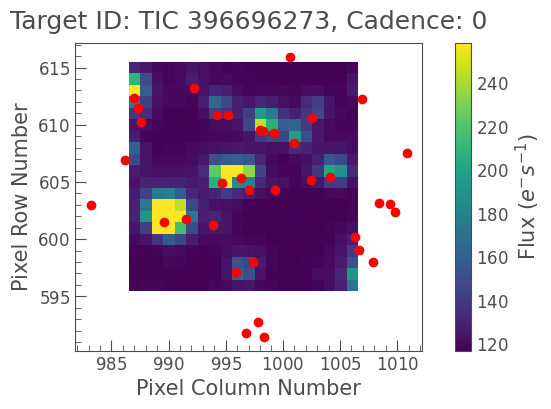

In [37]:
# make the tess wcs0
tess_wcs = get_wcs(tessda, ref_coords.ra, ref_coords.dec, ref_p1, ref_p2, roll, xreflect=False, yreflect=True) 

# apply the wcs to convert the gaia catalog coords to pixels
pix_x, pix_y = tess_wcs.all_world2pix(gaia_cat['coords'].ra, gaia_cat['coords'].dec, 0)

# plot
ax = tpf.plot()
ax.scatter(pix_y+midpoint[1]-tessda.naxis1.value/2, pix_x+midpoint[0]-tessda.naxis2.value/2, color='r')
# ax.scatter(r1, r2, color='r')
plt.show()

## Build Scene Model

In [38]:
# gaia red???? is probably the right one to use for tess images, check query func keywords for this
gaia_cat['jmag'].value

array([12.254, 16.204, 12.628, 15.858, 13.525, 13.322, 14.268, 15.978,
       13.851, 15.873, 14.317, 15.733, 14.907, 16.341, 13.575, 14.619,
       11.043, 13.559, 15.777, 15.486, 12.836, 14.639, 16.149, 15.401,
       12.211, 15.189, 16.42 , 14.6  , 14.022, 16.291, 15.176, 15.796,
       13.213, 15.998, 13.825, 16.212], dtype=float32)

In [39]:
tessda.mag_to_flux(gaia_cat['jmag'].value)

array([1881.0496  ,   49.476627, 1332.9081  ,   68.04563 ,  583.4455  ,
        703.3968  ,  294.3068  ,   60.925667,  432.11597 ,   67.11199 ,
        281.3197  ,   76.34847 ,  163.38054 ,   43.61144 ,  557.1861  ,
        213.01007 , 5738.5215  ,  565.45776 ,   73.316216,   95.851776,
       1100.5251  ,  209.12225 ,   52.04753 ,  103.65737 , 1957.0413  ,
        126.008606,   40.55087 ,  216.77039 ,  369.1477  ,   45.66674 ,
        127.526474,   72.04443 ,  777.67834 ,   59.81363 ,  442.58878 ,
         49.11343 ], dtype=float32)

In [40]:
gaia_cat

jmag,bmag,gmag,gflux,ang_sep,teff,logg,RUWE,coords,source_id
,,,,deg,K,,,"deg,deg,pc",
float32,float32,float32,float64,float64,float32,float32,float32,SkyCoord,str28
12.254,16.650219,15.098866,17194.9199832112,0.0007683652949916851,4065.55,nan,1.0869193,"65.30222374951447,-55.145169012194124,73.08601787058083",Gaia DR3 4778975067622266240
16.204,17.842638,17.469294,1937.4446060374999,0.007301823040476735,5339.8003,4.6618,1.0118041,"65.3148943451276,-55.14521912425681,3916.325593617499",Gaia DR3 4778975063327230592
12.628,13.819347,13.543228,72053.59702748689,0.011377517651192466,6021.928,4.2459,0.99152994,"65.29685968867182,-55.154940706579076,828.0890239017986",Gaia DR3 4778974689665144576
15.858,19.080233,18.033665,1152.0757760202782,0.017824722817210224,3501.0361,4.4374,1.0071007,"65.32823212992828,-55.13408565226563,671.0959163116867",Gaia DR3 4778972142749472640
13.525,16.437883,15.570011,11141.467946024166,0.025015087203421375,4200.482,4.6704,1.0003206,"65.2756863995768,-55.12415279968563,342.8569215389781",Gaia DR3 4778975136341741568
13.322,15.627077,14.989381,19019.298183208648,0.025436240126515852,4461.5137,4.5789,1.0075259,"65.2776100858782,-55.122954076482856,443.21969688540935",Gaia DR3 4778975136341741440
14.268,18.511915,17.085394,2759.2362036510963,0.02717607162430868,nan,nan,1.066243,"65.28431019522121,-55.11882628052499,241.22048930853168",Gaia DR3 4778975170701479296
15.978,17.767965,17.280277,2305.876103795077,0.02902936687528529,4813.609,4.5243,0.9332372,"65.32395591804816,-55.17024181810282,1449.0614609457332",Gaia DR3 4778971734727646720


136.91581631114408


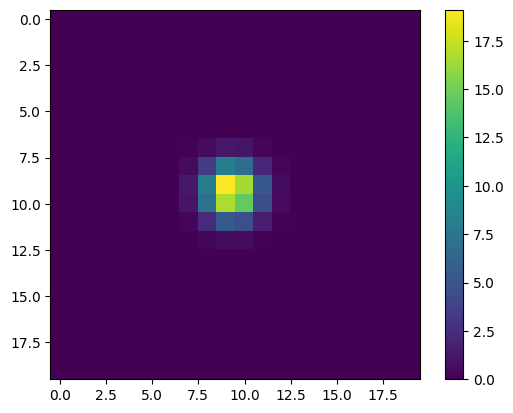

In [43]:
from scipy.stats import multivariate_normal
var = multivariate_normal(mean=[pix_x[10],pix_y[10]], cov=[[1,0],[0,1]])

# model = np.zeros([cutout_size, cutout_size, len(cat)])
model_grid = [[(i, j) for j in range(cutout_size)] for i in range(cutout_size)]
# fluxes = tessda.mag_to_flux(gaia_cat['gmag'].value)
# fluxes = gaia_cat['gflux'].value  # use gaia g flux
fluxes = tessda.mag_to_flux(gaia_cat['gmag'].value)  # use gaia g flux

# arr = var.pdf(list(zip(np.arange(0,1,.05), np.arange(0,1,.05))))
model = [multivariate_normal(mean=[pix_x[i],pix_y[i]], cov=[[1,0],[0,1]]).pdf(model_grid) * fluxes[i] for i in range(len(gaia_cat))]
print(sum(sum(model[0])))
plt.imshow(model[0])
plt.colorbar()
plt.show()


In [46]:
np.shape(model)

(36, 20, 20)

In [257]:
# calculate background to subtract from the tpf
bkg = utils.fit_bkg(tpf, polyorder=2)
np.shape(bkg)

(1077, 20, 20)

In [264]:
np.shape(tpf.flux.value[0] - bkg[0,:,:])
# np.shape(tpf[0])

(20, 20)

(36, 20, 20)
(20, 20, 36)
(20, 20)
(3, 36, 20, 20)


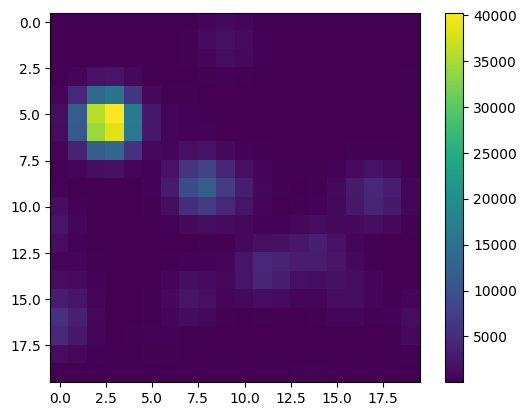

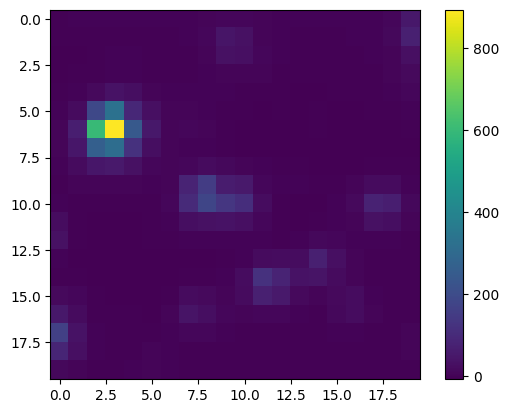

In [302]:
print(np.shape(model))
print(np.shape(np.moveaxis(model, 0, -1)))
print(np.shape(np.sum(model, axis=0)))
# print(np.sum(model, axis=(1,2)))
print(np.shape(np.gradient(model)))

plt.imshow((np.sum(model, axis=0)))
plt.colorbar()
# plt.clim(0,300)
plt.show()

plt.imshow(tpf.flux.value[0] - bkg[0,:,:])
plt.colorbar()
# plt.clim(0,300)
plt.show()


## Simplest linear model

In [83]:
# make the gradient a variable with just two dims we care about (g0, g1)
# shapes (36,20,20) and there are two of them
# g0, g1 = np.gradient(np.asarray(model),axis=(1,2))
g0, g1 = np.gradient(np.sum(np.asarray(model), axis=0))
print(np.shape(g0))
print(np.shape(g1))

(20, 20)
(20, 20)


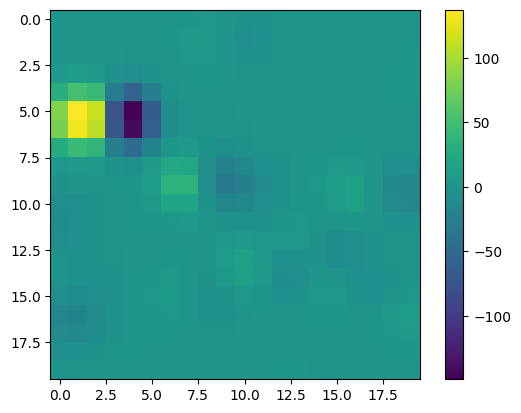

In [84]:
# plt.imshow(np.asarray(g1).sum(axis=0))
# plt.colorbar()
# plt.show()

plt.imshow(g1)
plt.colorbar()
plt.show()

In [173]:
np.shape(model)

(36, 20, 20)

In [268]:
np.shape(tpf_clean)

(1077, 20, 20)

In [296]:
np.shape(np.dot(X, w))
np.shape(np.reshape(np.dot(X, w), (20,20)))

(20, 20)

In [47]:
tpf.flux.shape

(1077, 20, 20)

In [85]:
# background subtraciton
bkg = utils.fit_bkg(tpf, polyorder=2)
# tpf_clean = tpf.flux.value[0] - bkg[0,:,:]
tpf_clean = tpf.flux.value - bkg

# set up the linear alg
mean = np.sum(np.asarray(model), axis=0) # the model image, np.ndarray shape (nrows, npixels), all sources summed together
g0, g1 = np.gradient(mean) # the gradient in x and y
# data = np.asarray(tpf.flux[0]) 
data = np.asarray(tpf_clean[0]) # the real image, np.ndarray shape (nrows, npixels)... make sure to use the background subtracted version!
X = np.vstack([mean.ravel(), g0.ravel(), g1.ravel()]).T

sigma_w_inv = X.T.dot(X)
B = X.T.dot(data.ravel())

w = np.linalg.solve(sigma_w_inv, B)   # tells you the offests you have to apply


/var/folders/kk/_9cq7r5j5nd8cxryt5p59v2c0000gn/T/ipykernel_11132/1638384103.py:2: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  bkg = utils.fit_bkg(tpf, polyorder=2)


In [311]:
np.shape(g0)

(20, 20)

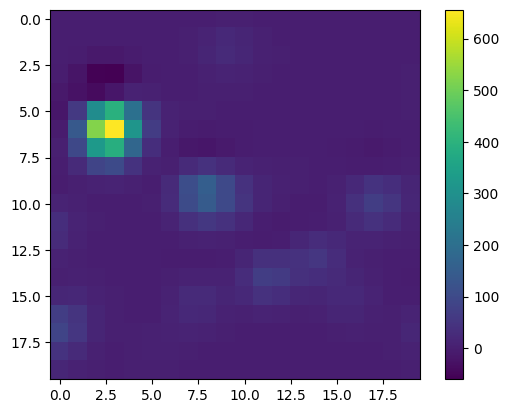

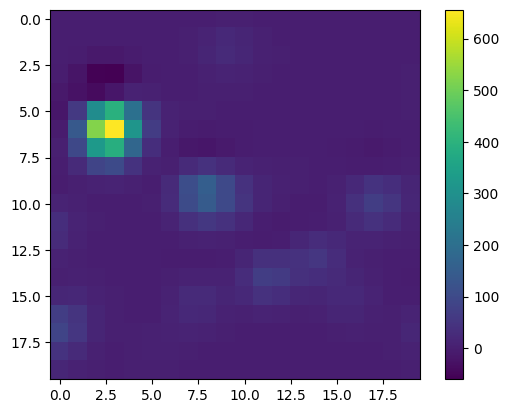

In [297]:
model1 = mean*w[0] + g0*w[1] + g1*w[2]
model2 = np.reshape(np.dot(X, w), (20,20))
# print(np.shape(mean*w[0]), np.shape(g0*w[1]), np.shape(g1*w[2]))

plt.imshow(model1)
plt.colorbar()
plt.show()

plt.imshow(model2)
plt.colorbar()
plt.show()

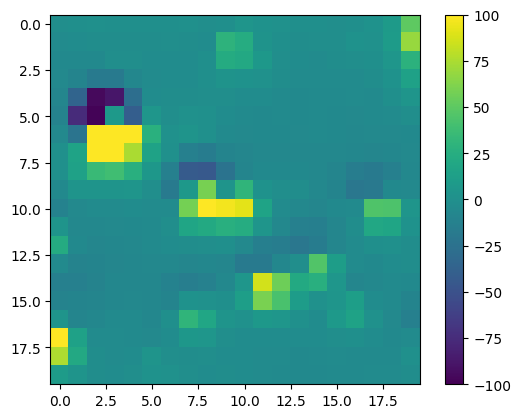

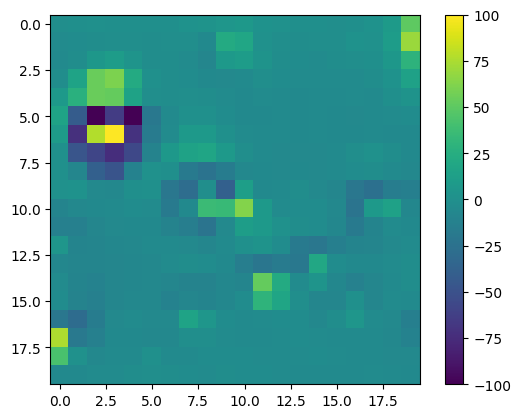

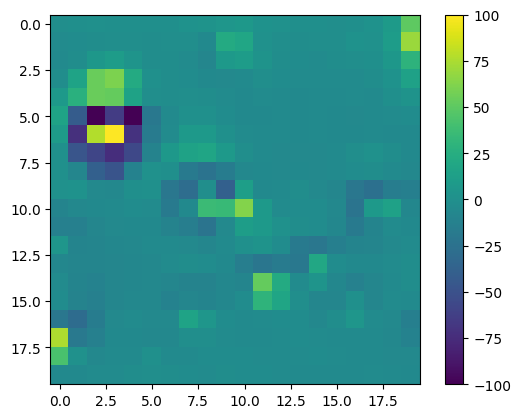

In [299]:
model1 = mean*w[0] + g0*w[1] + g1*w[2]
model2 = np.reshape(np.dot(X, w), (20,20))
plt.imshow(data-mean)
plt.colorbar()
plt.clim([-100,100])
plt.show()

plt.imshow(data-model1)
plt.colorbar()
plt.clim([-100,100])
plt.show()

plt.imshow(data-model2)
plt.colorbar()
plt.clim([-100,100])
plt.show()


- simple linear model as a polynomial in the gradient
- a small shift is func(starting_point) + grad_x(func)\*(alpha) + grad_y(func)\*(alpha )
- ^I think this is just a taylor expansion
- Check that model fluxes are as close as possible!!!
- check email for christina's notes on lin alg


- alter code to jointly fit the background with the sources
- to do this, add in a design matrix for the background
- currently, the only fixed variables are the source shapes and the source brightnesses
- add the errors (see screenshots + christina's notes)
    - Data divided by the errors of the data squared
    - for bright sources, error is sqrt(n)
- look at this over time in tess, make plot of position change over time
    - this will have to be extracted from the weights
    - g0 is delt_flux / delta_position
    - w is the change is distance (dx in row and column position)
    - check that this all makes sense
- Do all this for a larger TESS image
- then add elements to the design matrix so that you can fit non-uniform distortions (how much does the position of the psf change as a function of position of the detector)
    - design matrix which is an additional function of position on the detector
    - array that is [col, pos, pix] and [row, pos, pix]


In [ ]:
# # line from christina about the errors
# w = np.linalg.solve(A.T.dot(A/err[:, None]**2), A.T.dot(data/err**2))

In [381]:
n = 20 # the number of data points
m = 4 # the order of our polynomial
x = np.linspace(-1, 1, n)
A = np.vstack([x**idx for idx in range(m)]).T

# In this step, I'm going to make some fake data for us to fit
true_w = np.random.normal(size=m)
data = A.dot(true_w) + np.random.normal(0, 0.1, size=x.shape[0])
error = np.ones(x.shape[0]) * 0.1

bad_idx = np.random.choice(np.arange(n), 1)
data[bad_idx] += np.random.normal(0, 5, size=1)
error[bad_idx] += 5

fig, ax = plt.subplots()
plt.errorbar(x, data, error, c='k', ls='')
ax.set(xlabel='x', ylabel='data', title='Fake Data')

best_fitting_w = np.linalg.solve(A.T.dot(A), A.T.dot(data))

In [388]:
error[:, None]
A.T.dot(A/error[:, None])  
print(np.shape(A))
print(np.shape(error[:, None]**2))


(20, 4)
(20, 1)


In [405]:
print(np.shape(X))
print(np.shape((err.ravel()[:, None]**2)))
print(np.shape(X.T.dot(X) ))

# print(np.shape(X/(err.ravel()[:, None]**2)))
print(np.shape(data))
print(np.shape((data/err**2).ravel()))
# print(np.shape(data.ravel()))
# print(np.shape(B))
# print(np.shape(sigma_w_inv))


# X.T.dot(X/(err.ravel()[:, None]**2))   

(400, 4)
(400, 1)
(4, 4)
(20, 20)
(400,)


## Fit w/ Const Background

In [417]:
# try simultaneous fitting with a CONSTANT background flux
# background subtraciton
# bkg = utils.fit_bkg(tpf, polyorder=2)
tpf_flux = tpf.flux.value 
tpf_err = tpf.flux_err.value

# set up the linear alg
mean = np.sum(np.asarray(model), axis=0) # the model image, np.ndarray shape (nrows, npixels), all sources summed together
g0, g1 = np.gradient(mean) # the gradient in x and y
# data = np.asarray(tpf.flux[0]) 
data = np.asarray(tpf_flux[0]) # the real image, np.ndarray shape (nrows, npixels)... make sure to use the background subtracted version!
err = np.asarray(tpf_err[0])
X = np.vstack([mean.ravel(), g0.ravel(), g1.ravel(), np.ones_like(mean).ravel()]).T   # X is called A in Christina's notes

# # version without errors
# sigma_w_inv = X.T.dot(X)   
# B = X.T.dot(data.ravel())

# version with errors
sigma_w_inv = X.T.dot(X/(err.ravel()[:, None]**2))    
B = X.T.dot((data/err**2).ravel())

w = np.linalg.solve(sigma_w_inv, B)   # tells you the offests you have to apply
print(w)


[  1.41889446  -1.17861027  -0.30531688 120.40124869]


In [424]:
np.shape(X)
np.shape(err.ravel()[:, None])

print(X[:5])
print(err.ravel()[:, None][:5])
print((X/(err.ravel()[:, None]))[:5])

[[ 4.40090733e-06  6.18336886e-04  3.20316361e-05  1.00000000e+00]
 [ 3.64325434e-05  5.11886464e-03  5.32789841e-05  1.00000000e+00]
 [ 1.10958876e-04  1.55902811e-02  4.40494181e-05  1.00000000e+00]
 [ 1.24531380e-04  1.74754177e-02 -9.69132634e-06  1.00000000e+00]
 [ 9.15762229e-05  7.26360884e-03  1.64562986e-03  1.00000000e+00]]
[[0.33586925]
 [0.33437264]
 [0.33290294]
 [0.33437887]
 [0.3333985 ]]
[[ 1.31030373e-05  1.84100474e-03  9.53693612e-05  2.97734905e+00]
 [ 1.08957908e-04  1.53088621e-02  1.59340143e-04  2.99067532e+00]
 [ 3.33306988e-04  4.68313113e-02  1.32319103e-04  3.00387856e+00]
 [ 3.72425986e-04  5.22623268e-02 -2.89830706e-05  2.99061961e+00]
 [ 2.74674977e-04  2.17865678e-02  4.93592473e-03  2.99941369e+00]]


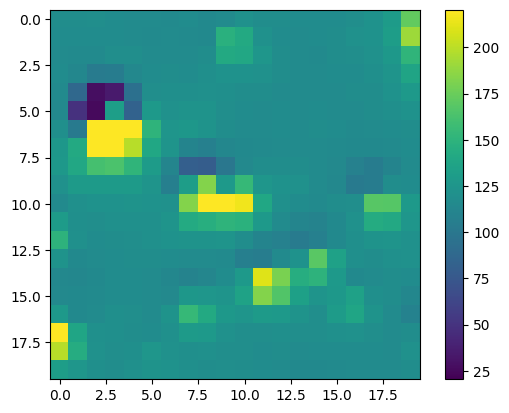

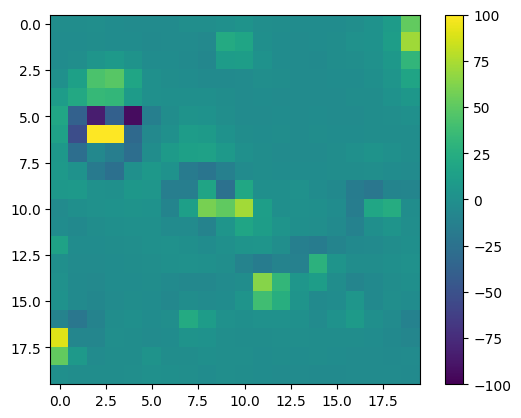

In [408]:
# model1 = mean*w[0] + g0*w[1] + g1*w[2]
model2 = np.reshape(np.dot(X, w), (20,20))
plt.imshow(data-mean)
plt.colorbar()
plt.clim([-100,100] + w[3])
plt.show()

plt.imshow(data-model2)
plt.colorbar()
plt.clim([-100,100])
plt.show()


## Fit w/ Polynomial Background

In [ ]:
# Note! We need to rescale R and C to be fractional positions on the detector (go from -.5 to .5) in order to avoid precision errors when we go to larger detector sizes

In [306]:
# Set up grid for calculating bkg polynomial
R, C = np.mgrid[: tpf.shape[1], : tpf.shape[2]].astype(float)
R -= tpf.shape[1] / 2
C -= tpf.shape[2] / 2
R /= tpf.shape[1]
C /= tpf.shape[2]

print(np.shape(R), np.shape(C))

# OLD DO NOT USE
def func(tpf, polyorder=1):
    # Design matrix
    A = np.vstack(
        [
            R.ravel() ** idx * C.ravel() ** jdx
            for idx in range(polyorder + 1)
            for jdx in range(polyorder + 1)
        ]
    ).T

    return A

# gives A = 1 + x + y + xy
A = utils.build_A_matrix(R, C, polyorder1=1, polyorder2=1)

# print(np.shape(A))
# # A[14:24,:]


(30, 30) (30, 30)


In [96]:
print(A.shape)
print(g0.ravel().shape)
print((g0.ravel() * A.T).T.shape)
print((g0.ravel() * g1.ravel().T).T.shape)


(400, 4)
(400,)
(400, 4)
(400,)


In [98]:
# try simultaneous fitting with a CONSTANT background flux
# background subtraciton
# bkg = utils.fit_bkg(tpf, polyorder=2)
tpf_flux = tpf.flux.value 
tpf_err = tpf.flux_err.value

# set up the linear alg
mean = np.sum(np.asarray(model), axis=0) # the model image, np.ndarray shape (nrows, npixels), all sources summed together
g0, g1 = np.gradient(mean) # the gradient in x and y
# data = np.asarray(tpf.flux[0]) 
data = np.asarray(tpf_flux[0]) # the real image, np.ndarray shape (nrows, npixels)... make sure to use the background subtracted version!
err = np.asarray(tpf_err[0])


In [99]:
# add A (the design matrix for the background polynomial) to X (the design matrix for the gaussian star model)
X = np.vstack([mean.ravel(), g0.ravel(), g1.ravel(), A.T]).T
# print(np.shape(X))

# # version with no errors
# sigma_w_inv = X.T.dot(X)
# B = X.T.dot(data.ravel())

# version with errors
sigma_w_inv = X.T.dot(X/(err.ravel()[:, None]**2))    
B = X.T.dot((data/err**2).ravel())


# do the solve
w = np.linalg.solve(sigma_w_inv, B)   # tells you the offests you have to apply
print(w)


[  1.41974467  -1.18133428  -0.30307044 120.29900009  -1.18778364
  -3.22572017 -10.7417471 ]


In [100]:
np.shape(X)
np.shape(err.ravel()[:, None])
# np.shape(w)

(400, 1)

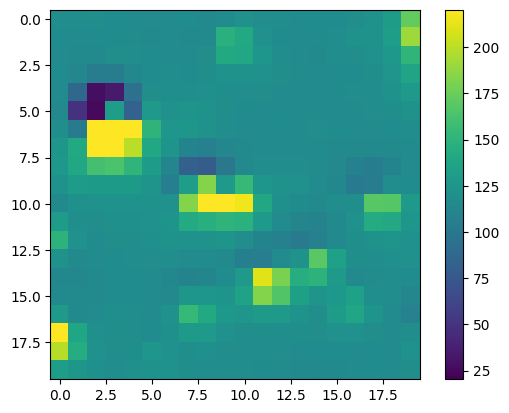

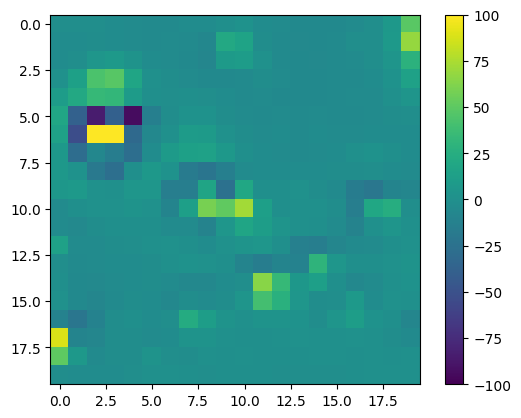

In [101]:
model2 = np.reshape(np.dot(X, w), (20,20))
plt.imshow(data-mean)
plt.colorbar()
plt.clim([-100,100] + w[3])
plt.show()

plt.imshow(data-model2)
plt.colorbar()
plt.clim([-100,100])
plt.show()


In [348]:
np.shape(X[:,3:])

(400, 4)

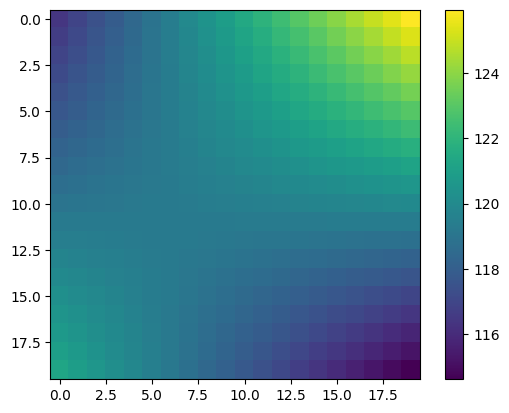

In [350]:
bkg = np.reshape(np.dot(X[:,3:], w[3:]), (20,20))
plt.imshow(bkg)
plt.colorbar()
# plt.clim([-100,100] + w[3])
plt.show()

## Fit with position dependent distortion

In [320]:
# apply the wcs to convert the catalog coords to pixels
pix_x, pix_y = tess_wcs.all_world2pix(cat['ra'], cat['dec'], 0)
pix_x, pix_y = tess_wcs.all_world2pix(gaia_cat['ra'], gaia_cat['dec'], 0)

tpf_flux = tpf.flux.value 
tpf_err = tpf.flux_err.value

data = np.asarray(tpf_flux[0]) # the real image, np.ndarray shape (nrows, npixels)... make sure to use the background subtracted version!
err = np.asarray(tpf_err[0])


In [309]:
# cartesian coordinate dependence

# Grid for calculating polynomial
R, C = np.mgrid[: tpf.shape[1], : tpf.shape[2]].astype(float)
R -= tpf.shape[1] / 2
C -= tpf.shape[2] / 2
R /= tpf.shape[1]
C /= tpf.shape[2]

print(np.shape(R), np.shape(C))

# nested b/c we run twice, once on each orbit
def func(tpf, polyorder=1):
    # Design matrix
    A = np.vstack(
        [
            R.ravel() ** idx * C.ravel() ** jdx
            for idx in range(polyorder + 1)
            for jdx in range(polyorder + 1)
        ]
    ).T

    return A

A = func(tpf, polyorder=1)

# print(np.shape(A))
# # A[14:24,:]


(30, 30) (30, 30)


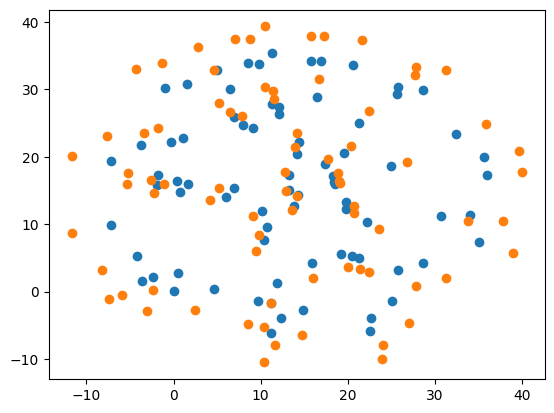

In [310]:
def distort_radially(x, y, x0, y0, distortion_constant):
    """Distorts the x and y positions radially by some constant, centered on a point (x0,y0)."""
    # Calculate differences between each point and the center point
    dx = x - x0
    dy = y - y0

    # Calculate radial distance
    radial_distance = np.sqrt(dx**2 + dy**2)

    # Scale the radial distance by the distortion constant
    distorted_distance = radial_distance * distortion_constant

    # Calculate new coordinates
    new_x = x0 + (dx * distorted_distance / radial_distance)
    new_y = y0 + (dy * distorted_distance / radial_distance)

    return new_x, new_y

r_x, r_y = distort_radially(pix_x, pix_y, ref_p1, ref_p2, 1.2)
plt.scatter(pix_x,pix_y)
plt.scatter(r_x, r_y)
plt.show()
# take the gradient in radial coordinates

In [311]:
model_grid = [[(i, j) for j in range(cutout_size)] for i in range(cutout_size)]
r_x, r_y = distort_radially(pix_x, pix_y, ref_p1, ref_p2, 1.2)
np.shape(pix_x)

(78,)

In [312]:
# if a function of position
# Source distortion as function of x position: w1*g0*x + w2*g0*x^2
# Source distortion as function of radial position: w1*g0*rad + w2*g0*rad^2 
# I can bundle all the offset terms (the columns of 1s), but I will need it for the radial column


In [313]:
# make model where the positions of the sources are radially distorted
r_x, r_y = distort_radially(pix_x, pix_y, ref_p1, ref_p2, 1.2)

# from scipy.stats import multivariate_normal

# model = np.zeros([cutout_size, cutout_size, len(cat)])
model_grid = [[(i, j) for j in range(cutout_size)] for i in range(cutout_size)]
# fluxes = tessda.mag_to_flux(gaia_cat['gmag'].value)
# fluxes = gaia_cat['gflux'].value  # use gaia g flux
fluxes = tessda.mag_to_flux(gaia_cat['gmag'].value)  # use gaia g flux

r_model = [multivariate_normal(mean=[r_x[i],r_y[i]], cov=[[1,0],[0,1]]).pdf(model_grid) * fluxes[i] for i in range(len(gaia_cat))]

# # print(sum(sum(r_model[0])))
# plt.imshow(np.sum(model, axis=0))
# plt.colorbar()
# plt.show()

# plt.imshow(np.sum(r_model, axis=0))
# # plt.imshow(np.sum(r_model, axis=0)-np.sum(model, axis=0))
# plt.colorbar()
# plt.show()


In [314]:
# calculate gradient
mean = np.sum(np.asarray(r_model), axis=0) # the model image, np.ndarray shape (nrows, npixels), all sources summed together
g0, g1 = np.gradient(np.sum(np.asarray(r_model), axis=0))

# SHOULDN'T NEED THIS calculate the radial gradient
# df/dr = (df/dx)/(2x) + (df/dy)/(2y)
# gr = g0/(2*R) + g1/(2*C)

# plt.imshow(gr) 
# plt.show()


In [317]:
# radial coordinate dependence

# Grid that contains distance from center
# NOTE: Eventually needs to be distance from the center of the optics, not the cut out

# center = (ref_p1,ref_p2)
# center = (0,0)
# r = np.sqrt( (x-center[0])**2 + (y-center[1])**2 )

# Grid for calculating polynomial
R, C = np.mgrid[: tpf.shape[1], : tpf.shape[2]].astype(float)

# Subtract the reference pixel and then scale to the size of the FULL detector
dx = (R - ref_p1) / tpf.shape[1]
dy = (C - ref_p2) / tpf.shape[2]

rad = np.sqrt(dx**2 + dy**2)
theta = np.arctan2(dy, dx)   # we don't need theta for now, so don't need to stack into the design matrix

print(rad.shape)

def build_A_matrix(M1, M2, polyorder1=1, polyorder2=1):
    # allow for integers or arrays for the polyorders
    if isinstance(polyorder1, int):
        polyorder1 = np.arange(polyorder1+1)
    if isinstance(polyorder2, int):
        polyorder2 = np.arange(polyorder2+1)
    
    # Design matrix
    A = np.vstack(
        [
            M1.ravel() ** idx * M2.ravel() ** jdx
            for idx in polyorder1
            for jdx in polyorder2
        ]
    ).T

    return A

# terms for the radial distorions
# gives Ar0 = g0 + r*g0 + r^2*g0
Ar0 = build_A_matrix(rad, g0, polyorder1=2, polyorder2=[1])
Ar1 = build_A_matrix(rad, g1, polyorder1=2, polyorder2=[1])

print(np.shape(Ar1))



(30, 30)
(900, 3)


In [315]:
# This will give the background polynomial
# gives A = 1 + x + y + xy
A = utils.build_A_matrix(R, C, polyorder1=1, polyorder2=1)

In [325]:
np.sqrt(.4814**2 + 3.4121**2)

3.445892100748368

In [321]:
# add A (the design matrix for the background polynomial) to X (the design matrix for the gaussian star model)
# X = mean + (g0 + r*g0 + r^2*g0) + (g1 + r*g1 + r^2*g1) + (1 + x + y + xy)
X = np.vstack([mean.ravel(), Ar0.T, Ar1.T, A.T]).T
print(np.shape(X))

# # version with no errors
# sigma_w_inv = X.T.dot(X)
# B = X.T.dot(data.ravel())

# version with errors
sigma_w_inv = X.T.dot(X/(err.ravel()[:, None]**2))    
B = X.T.dot((data/err**2).ravel())


# do the solve
w = np.linalg.solve(sigma_w_inv, B)   # tells you the offests you have to apply
print(w)


(900, 11)
[  0.18135141  -2.05626994   0.4814082    9.69511725  -1.65873083
   3.41213229  -0.58626161 126.68635487   3.34916695  -8.38421666
 -43.97321336]


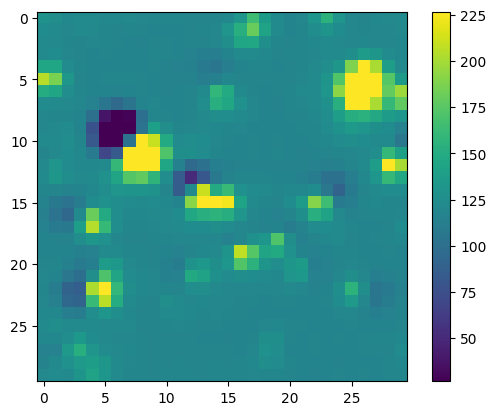

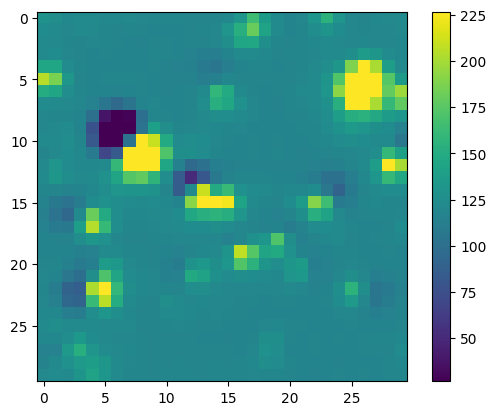

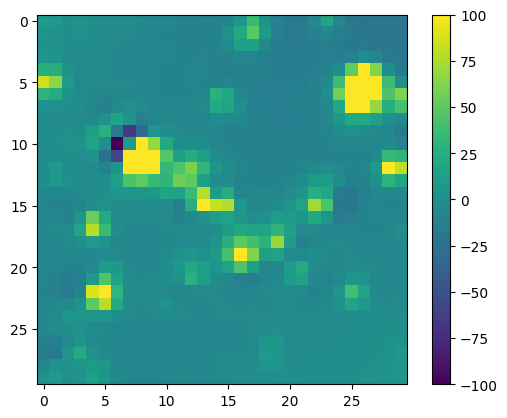

In [324]:
plt.imshow(data-np.sum(np.asarray(r_model), axis=0))
plt.colorbar()
plt.clim([-100,100] + w[7])
plt.show()

plt.imshow(data-mean)
plt.colorbar()
plt.clim([-100,100] + w[7])
plt.show()

model2 = np.reshape(np.dot(X, w), (cutout_size,cutout_size))
plt.imshow(data-model2)
plt.colorbar()
plt.clim([-100,100])
plt.show()

27.93631144985578

# cont

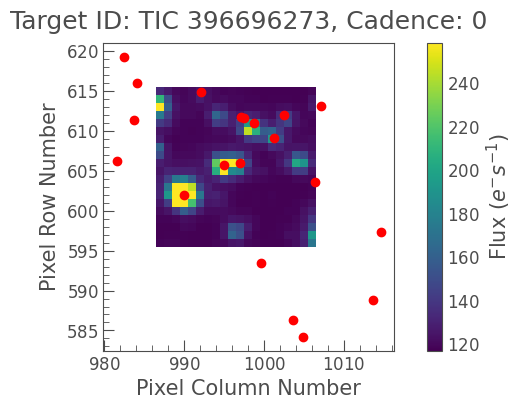

In [66]:
# OLD JANKY COORD MATCHING (doesn't use wcs0)
# our only known information is the RA, DEC, and roll for the middle of the image
# extract those
ra = tpf.meta['RA_OBJ']
dec = tpf.meta['DEC_OBJ']
roll = Angle('55d').radian   # idk I'm making this up right now and it's in degrees


pixel_scale = 21 / 3600   # deg per pixel

px1 = ((cat['ra'] - ra)/ pixel_scale + midpoint[1])
px2 = ((cat['dec'] - dec)/ pixel_scale + midpoint[0]) 

# r1, r2 = rotate(midpoint, px2, px1, np.pi/4)
r1, r2 = rotate(midpoint, px2, px1, roll)


ax = tpf.plot()
ax.scatter(r2, r1, color='r')
# ax.scatter(r1, r2, color='r')
plt.show()